#CSE 5525 Final Project - Digits Tutorial
CSE 5525 SP21

**Team:**

Jinhee Lee, Jack Loth, Joe Humes, and Kawthar Shafie Khorassani 


In [1]:
# Setup Your Environment

import IPython

import librosa
import librosa.display

import scipy.io.wavfile
from scipy.fft import dct

from os import listdir

import numpy as np
import numpy.fft as npfft 

import tqdm.notebook as tq

import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

In this tutorial, we will be using the [**Free Spoken Digit Dataset (FSDD)**](https://github.com/Jakobovski/free-spoken-digit-dataset.git) to create a digit recognizer with neural networks. FSDD is an audio/speech dataset with recordings of saved as wav files of spoken digits. It consists of the following: 
* 6 speakers
* 3,000 recordings (50 of each digit per speaker)
* English pronunciations

In [2]:
!git clone https://github.com/Jakobovski/free-spoken-digit-dataset.git

Cloning into 'free-spoken-digit-dataset'...
remote: Enumerating objects: 4182, done.
remote: Counting objects: 100% (510/510), done.
remote: Compressing objects: 100% (510/510), done.
remote: Total 4182 (delta 2), reused 501 (delta 0), pack-reused 3672
Receiving objects: 100% (4182/4182), 30.44 MiB | 19.23 MiB/s, done.
Resolving deltas: 100% (79/79), done.


### **Dataset**

First, write a function that loads a file and returns the signal and sampling frequecy, also known as the sampling rate. (Hint: [this library](https://librosa.org/doc/latest/generated/librosa.load.html#librosa.load) can make it easy to load in the file)

In [ ]:
def loadaudiofile(filename):
  # YOUR CODE GOES HERE


  return signal, sf

####Solution

In [3]:
def loadaudiofile(filename):
  signal, sf = librosa.load(filename)
  return signal, sf

####Generate a display of an audio signal from the dataset using MatPlotLib:

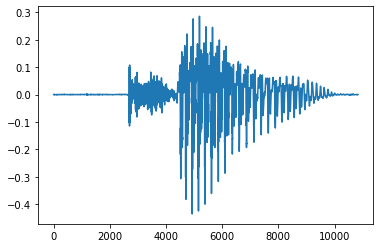

In [4]:
# Load the data directory and display an audio file
data_dir = 'free-spoken-digit-dataset/recordings/'

# Pass a file from data_dir to display an audio signal
y, signal= librosa.load(data_dir + '2_lucas_29.wav')
plt.plot(y);

### No Transformation

In this section, we will try using the untransformed data in a basic, out of the box neural network. Below, the data will be read in using the function we defined above. Note that the data being read in is padded to the length of the longest array so that every data point is the same size.

In [ ]:
N = 3000
largest = 50335 # The length of the longest data point
X = np.zeros((N, largest))
y = np.zeros((N))

for i, filename in tq.tqdm(enumerate(listdir('free-spoken-digit-dataset/recordings/')), total=N):
  data, sf = loadaudiofile('free-spoken-digit-dataset/recordings/' + filename)
  X[i] = np.pad(data, (0,largest-data.shape[0]))
  y[i] = filename[0]

Now that the data has been read in, it can be split into training and test sets. Use the train_test_split function from sklearn to do this, creating the arrays `X_train`, `X_test`, `y_train` and `y_test`.

In [ ]:
#Your code here

#### Solution

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)

Now that we have training and testing sets, we can see how accurate a basic classifier is when using this untransformed raw data. Below, set up a basic Multi-Layer Perceptron classifier from sklearn (documented [here](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html), and fit it to the training sets you created above. Name this classifier `clf`. Note that the fitting process may take several minutes to complete. If the network does not converge by the time training finishes, try increasing `max_iterations`.

In [ ]:
# Your code here

#### Solution

In [ ]:
clf = MLPClassifier(random_state=1, max_iter=50)
clf.fit(X_train, y_train)

Now that the model has been trained, we can evaluate the performance by checking its accuracy on both the training and testing datasets. 

In [ ]:
# Get accuracy of model
print('Training accuracy: {}'.format(clf.score(X_train, y_train)))
print('Test accuracy: {}'.format(clf.score(X_test, y_test)))

As we can see, the classifier isn't able to perform very well on the test set, resulting in an extremely low accuracy. However, by transforming the input data, we may be able to produce better results even when using the same or a similar model structure.

### FFT

The Fast Fourier Transform is one common way to transform signal data like this. This transformation converts the data from being in the time domain to the frequency domain. While advanced readers may be interested in implementing this themselves (such readers would find [this tutorial](https://towardsdatascience.com/fast-fourier-transform-937926e591cb) and similar ones helpful), the numpy implementation is optimized for efficiency, so we will be using this. Note that the FFT algorithm returns complex numbers, which are incompatible with most models, so we will be converting each value to its magnitude. 

In [ ]:
X_fft = npfft.fft(X)
X_fft = np.abs(X_fft)

Now that we have a new dataset, we must create another train/test split. Perform this operation below using the same method and variable names as above. 

In [ ]:
# Your code here

#### Solution

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_fft, y, stratify=y, random_state=1)

Use the same model structure to train another model on the new data. Be sure to name your classifier `clf` once again.

In [ ]:
# Your code here

#### Solution

In [ ]:
clf = MLPClassifier(random_state=1, max_iter=50)
clf.fit(X_train, y_train)

Now, we can check the accuracy of the classifier on the transformed training and testing sets.

In [ ]:
# Get accuracy of model
print('Training accuracy: {}'.format(clf.score(X_train, y_train)))
print('Test accuracy: {}'.format(clf.score(X_test, y_test)))

Performance is notably improved, particularly on the accuracy of the test set. However, performance can still be improved with more complex transformations.

### **MFCC**

In this section we will use Mel-Frequency Cepstral Coefficients (MFCC) as the features used as input to our neural network. The general process for extracting these features from a signal $x[n]$ is as follows:


1.   Split the overall signal $x[n]$ into shorter, overlapping frames $\{x_1,x_2,\dots ,x_k\}$
2.   Use FFT to transform signal into Fourier domain
3.   Apply $M$ filters to signal and sum the energy in each filter
4.   Use the discrete cosine transform (DCT) to calculate cepstral coefficients

We will go through each step in detail. 


####Signal frames

Next, fill in the function to split the signal into shorter frames. In particular, let signal $x$ have length $N$. We would like to split it into a new array of shape $(r,w)$, where $r$ is the number of frames and $w$ is the size of each frame (in samples). 

Because we may have different sampling rates, we will use two parameters to control this: 
*   `frame_size`
 * The number of samples in each frame
*   `step_size`
 * The number of samples between each new frame. This can be less than the frame size since the frames are allowed to overlap

These are typically given in ms. You can convert between ms and samples by simply multiplying the param in ms by the sampling rate. 

HINT: Creating a sliding window is a bit tricky, so you can use the `slidingWindow` function defined below to help you.

In [5]:
def slidingWindow(x, step_size, shape):
  stride = x.strides[0]
  row_stride = step_size * stride
  x = np.lib.stride_tricks.as_strided(x, shape, strides=(row_stride,stride)).copy()
  return x

In [ ]:
def signalToFrames(signal, sf, frame_size = 0.025, step_size=0.01):
  # YOUR CODE GOES HERE

  
  return frames 

####Solution

In [7]:
def signalToFrames(signal, sf, frame_size = 0.025, step_size=0.01):

  length_samples = int(frame_size * sf)
  step_samples = int(step_size * sf)

  num_frames = np.ceil(float(signal.shape[0] - length_samples) / step_samples).astype(int)
  new_length = (num_frames * step_samples) + length_samples

  x = np.pad(signal,(0, (new_length - signal.shape[0]).astype(int)))
  frames = slidingWindow(x, step_samples, (int((new_length - length_samples) / step_samples), length_samples))

  frames *= np.hamming(length_samples)
  
  return frames

####Mel scale

Before we create a main MFCC function, we need to create some helper methods. We will start by creating two methods to convert a numpy array of frequencies to the mel scale and back. To convert to the mel scale:

$f_{mel} = 1125 \log\big(1 + \frac{f}{700}\big)$

To convert back:

$f = 700 \big(e^{f_{mel}/1125} - 1\big)$


In [ ]:
def mel_freq(f):
  # YOUR CODE GOES HERE

  return f_mel

def mel_inverse(f_mel):
  # YOUR CODE GOES HERE

  return f

####Solution

In [8]:
def mel_freq(f):
  # YOUR CODE GOES HERE

  f_mel = 1125 * np.log(1+ (f/700))
  return f_mel

def mel_inverse(f_mel):
  # YOUR CODE GOES HERE
  
  f = 700 * (np.exp(f_mel/1125) - 1)
  return f

####Calculating filter frequencies

The following function will convert an array of frequencies to the corresponding FFT 'bin'. In an $N$-FFT, $N$ will correspond with the sampling frequency $f_s$. So if $f_s=16000$ and $N$ = 512, the fuction would convert $f = 8000$ to $256$.

In [9]:
def fft_bin(freqs, N, sf):
  return np.floor((N+1) * freqs / sf)

Next we would like to create several filters that we can apply to our signal frames. First we can calculate the frequencies for the start and end of each filter.


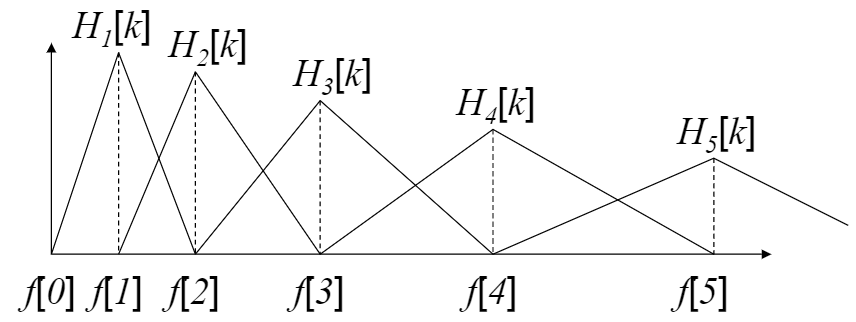

As can be seen in the figure, each filter will start at the center frequency of the previous filter, and end at the center frequency of the next filter. Therefore we need to caluate the center frequency of each filter, as well as the start of the first filter $(0)$ and the end of the last filter $(\frac{F_s}{2})$

These frequencies should be spaced evenly throughout the mel spectrum, starting with 0 and ending with $\text{mel}(f_s/2)$ (Hint: use [np.lispace](https://numpy.org/doc/stable/reference/generated/numpy.linspace.html)). 

While these frequencies should be even throughout the mel spectrum, you will need to convert them back to the domain of the N-point FFT. The `mel_inverse()` and `fft_bin()` functions can help with this.

In [ ]:
def getFilterFrequencies(num_filters, sf, N):
  # YOUR CODE GOES HERE


  return freqs

####Solution

In [10]:
def getFilterFrequencies(num_filters, sf, N):
  # YOUR CODE GOES HERE

  f0_mel = mel_freq(0)
  fh_mel = mel_freq(sf/2)

  freqs_mel = np.linspace(f0_mel, fh_mel, num_filters+2)
  freqs_hz = mel_inverse(freqs_mel)

  freqs = fft_bin(freqs_hz, N, sf)

  return freqs


####Filter bank

Now we can use these frequencies to construct an array that represents the filters. To do this, we need to construct an array of size $(m , k)$ where $m$ is the number of filters and $k$ is $\frac{N}{2} + 1$, and fill it with values according to the following:

$ H[m,k] = 
\begin{cases}
0 & k < f[m-1]\\
\frac{2(k-f[m-1])}{(f[m+1]-f[m-1])(f[m]-f[m-1])} & f[m-1] \leq k \leq f[m]\\
\frac{2(f[m+1] - k)}{(f[m+1]-f[m-1])(f[m+1]-f[m])} & f[m] \leq k \leq f[m+1]\\
0 & k > f[m+1]\\
\end{cases}
$

Each $f$ is one of the frequencies calculated using the `getFilterFrequencies()` function.

In [ ]:
def filterbank(num_filters, sf, N):
  # YOUR CODE GOES HERE
  

  return filters

####Solution

In [11]:
def filterbank(num_filters, sf, N):
  
  freqs = getFilterFrequencies(num_filters, sf, N)

  filters = np.zeros((num_filters, int(np.floor(N / 2 + 1))))
  for i in range(num_filters):

    left = int(freqs[i])
    center = int(freqs[i+1])
    right = int(freqs[i+2])

    for k in range(left, center):
      filters[i,k] = (k - left) / (center - left)
    for k in range(center, right):
      filters[i,k] = (right - k) / (right - center)

  return filters

#### MFCC Function

Finally we will create the actual MFCC function. This function should take in a numpy array of length $N$ and return a new numpy array of length $(k,m)$, where $k$ is the number of frames and $m$ is the number of coeficcients. 

To calculate the coefficients, we need to go through the steps.


1.   Convert signal of size $N$ to arary of overlapping frames
2.   Take the $N$-point FFT of the signal (HINT: Use [npfft.rfft](https://numpy.org/doc/stable/reference/generated/numpy.fft.rfft.html))
3.   Get the periodogram-based power spectral estimate for each frame using $P_i(k) = \frac{1}{N}|S_i(k)|^2$, where $S_i$ is the $i$-th frame of the FFT
3.   Get the array of filters using `filterbank()`
4.   Take the dot product between the power spectrum and the filters array
5.   Take the DCT of the resulting array (Hint: use [scipy dct](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.dct.html))



In [ ]:
def mfcc(signal, sf, num_coefs=10, N=512, frame_length=0.025, frame_step=0.01):
  # YOUR CODE GOES HERE

  return dct_out

#### Solution

In [12]:
def mfcc(signal, sf, num_coefs=10, N=512, frame_length=0.025, frame_step=0.01):
  # YOUR CODE GOES HERE

  frames = signalToFrames(signal, sf, frame_size = 0.025, step_size=0.01)
  
  fft = npfft.rfft(frames, N, axis=1)
  pow = np.square(np.absolute(fft)) / N

  filters = filterbank(num_coefs, sf, N)

  filtered = pow @ np.transpose(filters)
  filtered = np.log(filtered)
  dct_out = dct(filtered, axis=1, norm='ortho')[:, 1 : (13)]
  return dct_out

#### Neural Network
Now that we have implemented the MFCC calculations, we can use it with a neural network model. First we will build a dataset using our MFCC function.

In [14]:
# Use MFCC to create dataset
N = 3000
X = np.zeros((N, 12))
y = np.zeros((N))
for i, filename in tq.tqdm(enumerate(listdir('free-spoken-digit-dataset/recordings/')), total=N):
  data, sf = librosa.load('free-spoken-digit-dataset/recordings/' + filename)
  mfccs = np.mean(mfcc(data, sf, 26, 512, 0.025), axis = 0)
  X[i] = mfccs
  y[i] = filename[0]
  
# Split data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)

Now we can use the [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) module from sklearn as our neural network module. Try playing with the parameters to see if you can increase the test accuracy. If the network does not converge by the time training finishes, try increasing `max_iterations`.

In [15]:
a = 0.0001
learning_rate = 0.001
max_iterations = 500
random_s = 1

# Train the MLP model (this may take a minute or so to run)
print('Training...')
clf = MLPClassifier(random_state=random_s, alpha = a, learning_rate_init=learning_rate, max_iter=max_iterations).fit(X_train, y_train)

# Get accuracy of model
print('\nTraining acuracy: {}'.format(clf.score(X_train, y_train)))
print('Test acuracy: {}'.format(clf.score(X_test, y_test)))

Training...

Training acuracy: 0.9182222222222223
Test acuracy: 0.8933333333333333


##**Pytorch Neural Network**

In this section, we will build a neural network using the Pytorch library, and utilize this network with our dataset. For more details on using Pytorch, please visit this link: https://pytorch.org/docs/stable/index.html

In [ ]:
# Setup Pytorch Environment
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

**NOTE:** This segment of code can be run on either a GPU or CPU by torch.device. If you're able to use a GPU, this can execute quicker!

In the Colab environement change the below setting to use a GPU: 

* Go to "Runtime" -> "Change runtime type" -> "Hardware accelerator" -> "GPU"

In [ ]:
# GPU or CPU setting
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(dev)

cpu


### Build a Neural Network using PyTorch.

PyTorch provdes a module nn with several neural network models and methods that can be used.Your class (Network class) will inherit from the nn.Module.

Generate your custom network using the following two mandatory functions: **__ init __**(self) and **forward**(self, t).

 1. **__ init __**(self) is used to define layers.
 
 2. **forward**(self, t) is used to specify the connections. 

The following code is a sample configuration of the network. The class defined: **SampleNetwork** has one hidden layer (15 hidden nodes) and one output layer(10 ouput nodes). The hidden Layer passes through the Relu activation function.

Take a look at this sample configuration and use it to decide how to generate your Network below:

In [ ]:
class SampleNetwork(nn.Module):
  def __init__(self,input_size):
    super().__init__()    
   
    # define layers       
    self.fc1 = nn.Linear(input_size, 15)   # input layer(# nodes: input size) -> hidden layer(# nodes: 15)
    self.fc2 = nn.Linear(15, 10)           # hidden layer(# nodes: 15) -> output layer(# nodes: 10),  We have 10 digits: classes       
    
  # define forward function
  def forward(self, t):       
    t=F.relu(self.fc1(t))   # used relu activation function here
    t=self.fc2(t)           # instead of using softmac here, we will use nn.CrossEntropyLoss() which contains softmax
         
    return t

Using the sample configuration above, build your own network below. 

You can see various nn models here: https://pytorch.org/docs/stable/nn.html

In [ ]:
class Network(nn.Module):   # Define your network here
  def __init__(self,input_size):
    super().__init__()   
    # YOUR CODE GOES HERE

  def forward(self, t):  
    # YOUR CODE GOES HERE

    return t

We will now set up the data into pytorch tensors to use the dataset with PyTorch. Tensor is the data structure (similar to a Numpy array), but it can be used for a GPU setting. 

You can read more about the Torch.Tensor: https://pytorch.org/docs/stable/tensors.html

In [ ]:
# set up the data into tensors
X_train_Tensor = torch.from_numpy(X_train).float().to(dev)
y_train_Tensor = torch.from_numpy(y_train).long().to(dev)
X_test_Tensor = torch.from_numpy(X_test).float().to(dev)
y_test_Tensor = torch.from_numpy(y_test).long().to(dev)

###Train

**Now that we have set up the data into tensors, Let's train the model!**


Use `nn.CrossEntropyLoss()` for a loss function. `CrossEntropyLoss()` calculates cross entropy loss from the log softmax results (softmax is a great function for the multiclass problem (We have 10 digits)). 



In the next step, get the predicted targets from your Network, and update parameters from the loss function and then utilize *backpropagation*.

Use your model below instead of the define class `SampleNetwork` to get the accuracy of a train dataset. 

In [ ]:
lr=0.001
batch_size=300
shuffle=True
epochs=1000

# Set the input size to MFCC Dataset's input Size
# Change the input size based on your dataset 
input_size=12 

# OPTION 1: Use the defined class SampleNetwork to check your results
network=SampleNetwork(input_size)  

# OPTION 2: Use your Model as your Network
#network = Network(input_size) 

# Define your Loss Function
lossFunc = nn.CrossEntropyLoss() 

### DEFINE Training Set
### Combine input data and target data as a train set for batch
train_set = TensorDataset(X_train_Tensor, y_train_Tensor)

### DEFINE Loader
### Slice train dataset as batch_size
loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size)

### DEFINE Optimizer
### You may utilize other optimizers (e.g. SGD: Stochastic Gradient Descent)
optimizer = optim.Adam(network.parameters(), lr=lr) 

### TRAIN Your Network using the Train Dataset
network.train()

for epoch in range(epochs):  
  for batch in loader: 
    # Get Training Accuracy 
    
        # YOUR CODE GOES HERE




####Solution

In [ ]:
lr=0.001
batch_size=300
shuffle=True
epochs=1000

# Set the input size to MFCC Dataset's input Size
# Change the input size based on your dataset 
input_size=12 

# OPTION 1: Use the defined class SampleNetwork to check your results
network=SampleNetwork(input_size)  

# OPTION 2: Use your Model as your Network
#network = Network(input_size) 

# Define your Loss Function
lossFunc = nn.CrossEntropyLoss() 

### DEFINE Training Set
### Combine input data and target data as a train set for batch
train_set = TensorDataset(X_train_Tensor, y_train_Tensor)

### DEFINE Loader
### Slice train dataset as batch_size
loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size)

### DEFINE Optimizer
### You may utilize other optimizers (e.g. SGD: Stochastic Gradient Descent)
optimizer = optim.Adam(network.parameters(), lr=lr) 

### TRAIN Your Network using the Train Dataset
network.train()

for epoch in range(epochs):  
  for batch in loader:    
    x_var = batch[0]                  # batch[0] is your input data
    targets = batch[1]                # batch[1] is your target data
    
    optimizer.zero_grad()             # before back prop set gradient as 0
    preds = network(x_var)            # predict from Network  
    
    loss = lossFunc(preds, targets)   # find loss from CrossEntropyLoss()   
    loss.backward()                   # Back propagation
    optimizer.step()                  # update parameters based on current gradient
  
  if epoch%200==0:
    ### GET TRAIN ACCURACY
    count=0
    correct=0
    network.eval()   
    with torch.no_grad():
      for batch in loader:  # TRAIN Set Loader
        x_var = batch[0]  
        targets = batch[1]  
        preds=network(x_var)      

        # Find the most accurate one's index and compare to targets
        batch_correct=preds.argmax(dim=1).eq(targets).sum().item() 
        batch_count=len(batch[0])
        
        count+=batch_count
        correct+=batch_correct

    network.train()
    accuracy=correct/count  
         
    print('Epoch {0}: Training accuracy {1}'.format(epoch,accuracy))

Epoch 0: Training accuracy 0.09866666666666667
Epoch 200: Training accuracy 0.7582222222222222
Epoch 400: Training accuracy 0.8031111111111111
Epoch 600: Training accuracy 0.8231111111111111
Epoch 800: Training accuracy 0.8444444444444444


###Accuracy

We can get test set accuracy from test dataset. We can visualize predicted labels and targets.

Create test dataset from X_test and y_test tensors, and also make test loader from test dataset.
And then, get test accuracy, and show predicted labels with true targets.




In [ ]:
# Generate Test Set
test_set = TensorDataset(X_test_Tensor, y_test_Tensor)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size) 

# Get Test Accuracy and display True + Predicted labels

  # YOUR CODE GOES HERE


#### Solution

In [ ]:
# Generate Test Set
test_set = TensorDataset(X_test_Tensor, y_test_Tensor)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size) 

# Get Accuracy
count=0
correct=0

network.eval()   
with torch.no_grad():
  for batch in test_loader:  # test set loader
    x_var = batch[0]  
    targets = batch[1]  
    preds=network(x_var)      

    TestLabel=targets
    PredictedTestLabel=preds.argmax(dim=1)

    batch_correct=preds.argmax(dim=1).eq(targets).sum().item()
    batch_count=len(batch[0])
    count+=batch_count
    correct+=batch_correct

network.train()
accuracy=correct/count

print('Test accuracy: ', accuracy)

print("True Labels")
print(TestLabel)

print("Predicted Labels")
print(PredictedTestLabel)


Test accuracy:  0.8453333333333334
True Labels
tensor([3, 9, 5, 6, 0, 4, 7, 6, 1, 2, 5, 3, 1, 0, 0, 7, 7, 1, 6, 4, 4, 5, 7, 8,
        6, 4, 2, 3, 3, 5, 8, 1, 7, 1, 1, 1, 5, 7, 3, 2, 4, 4, 5, 2, 1, 4, 5, 0,
        9, 9, 0, 9, 4, 0, 2, 5, 6, 0, 9, 8, 3, 0, 8, 9, 3, 4, 2, 0, 8, 4, 8, 7,
        8, 7, 2, 4, 1, 7, 9, 7, 9, 7, 0, 5, 2, 6, 0, 5, 3, 2, 3, 0, 7, 5, 8, 1,
        3, 5, 8, 8, 5, 9, 8, 0, 6, 5, 5, 9, 4, 8, 6, 0, 3, 4, 6, 4, 0, 2, 9, 8,
        3, 6, 4, 4, 1, 8, 7, 0, 0, 3, 3, 6, 3, 8, 8, 5, 5, 7, 9, 8, 5, 1, 6, 4,
        7, 5, 3, 5, 1, 8])
Predicted Labels
tensor([0, 7, 5, 6, 0, 4, 7, 6, 1, 2, 5, 3, 1, 0, 0, 7, 7, 1, 6, 4, 4, 5, 7, 8,
        6, 1, 2, 3, 7, 5, 8, 1, 9, 4, 1, 1, 5, 7, 3, 2, 4, 4, 1, 2, 1, 4, 5, 0,
        9, 9, 0, 9, 4, 0, 0, 7, 6, 2, 5, 2, 0, 0, 8, 1, 6, 4, 2, 0, 6, 4, 8, 7,
        8, 7, 2, 4, 1, 7, 0, 7, 9, 7, 0, 5, 3, 6, 0, 5, 3, 2, 3, 0, 7, 5, 8, 1,
        3, 5, 8, 8, 5, 9, 8, 0, 7, 5, 5, 9, 4, 8, 6, 0, 3, 4, 8, 4, 0, 2, 9, 8,
        3, 3, 4, 4, 1, 8, 7, 

### How accurate is your model? Do you have any ideas for how you can improve the performance?

**Extension:** Try the following experiments to improve your network and report on your findings:
* Use more layers
* Use activation functions
* Use different models

References: [http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/)